<a href="https://colab.research.google.com/github/ugsfume/Mplus/blob/main/Mplus_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [320]:
import zipfile
import requests
import os
import shutil
import torch
import sys
import numpy as np

In [321]:
models_url = "https://github.com/ugsfume/Mplus/archive/refs/heads/main.zip"
artemis_url = "https://github.com/optas/artemis/archive/refs/heads/master.zip"


def fetch_zip(zip_url, directory="./unzipped/", temp_dir="./"):
    # Clone the M+ dataset from https://github.com/mplusmuseum/collection-data into the directory specified.
    # This will download the dataset and extract it into the directory.

    # Check if directory exists, if not create it recursively.
    print("Checking if directory exists:", directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory created:", directory)

    # Download the zip file:
    print("Downloading zip file:", zip_url)
    r = requests.get(zip_url, stream=True)
    r.raise_for_status()

    # Save the zip file to a temporary directory:
    print("Saving zip file to temporary directory:", temp_dir)
    with open(temp_dir + "temp.zip", "wb") as f:
        shutil.copyfileobj(r.raw, f)

    # Unzip the zip file to the directory:
    print("Unzipping zip file to directory:", directory)
    with zipfile.ZipFile(temp_dir + "temp.zip", "r") as zip_ref:
        zip_ref.extractall(directory)

    # Clean up the temporary zip file:
    print("Cleaning up temporary zip file:", temp_dir + "temp.zip")
    os.remove(temp_dir + "temp.zip")

    print("Process complete.")

# Fetching the models
WARNING: Make sure you are running in a GPU instance.

In [322]:
fetch_zip(models_url, directory="./models/")
fetch_zip(artemis_url, directory="./artemis/")

Checking if directory exists: ./models/
Saving zip file to temporary directory: ./
Unzipping zip file to directory: ./models/
Cleaning up temporary zip file: ./temp.zip
Process complete.
Checking if directory exists: ./artemis/
Saving zip file to temporary directory: ./
Unzipping zip file to directory: ./artemis/
Cleaning up temporary zip file: ./temp.zip
Process complete.


In [323]:
!pip install -e ./artemis/artemis-master/
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/artemis/artemis-master
  Attempting uninstall: artemis
    Found existing installation: artemis 0.1
    Can't uninstall 'artemis'. No files were found to uninstall.
  Running setup.py develop for artemis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading the models

In [324]:
sys.path.insert(1, './artemis/artemis-master/')
image_model = torch.load("./models/Mplus-main/image2emotion.pt")
text_model = torch.load("./models/Mplus-main/text2emotion.pt")

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute o

In [325]:
image_model.eval()

ImageEmotionClassifier(
  (img_encoder): ResnetEncoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

./models/Mplus-main/images/Street Lamps_Wang Aihe.jpg


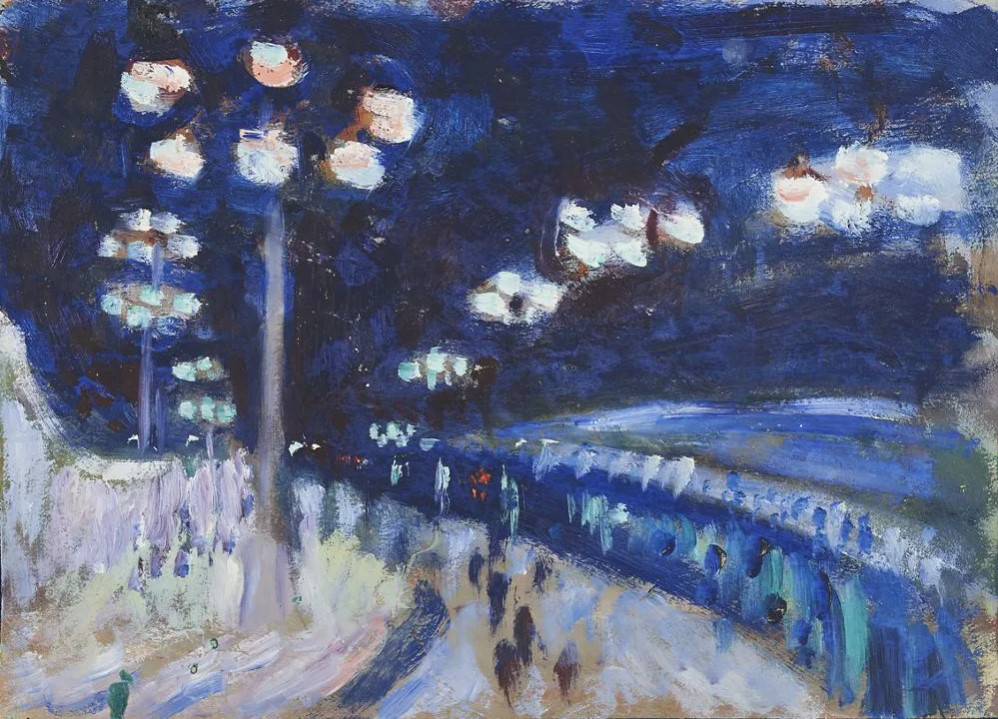

In [326]:
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
import glob

# img = Image.open('./models/Mplus-main/images/River of Light_Feng Guodong.jpg')
img_list = glob.glob('./models/Mplus-main/images/*.jpg')
print(img_list[0])
img = Image.open(img_list[0])
img

#Function that detects emotion in images

In [327]:
from torchvision import transforms
from torch import nn

def image_emotion_detection(image_in):
  transform = transforms.Compose([        # Defining a variable transforms
  transforms.Resize(256, Image.LANCZOS),                # Resize the image to 256×256 pixels
  transforms.ToTensor(),                 # Convert the image to PyTorch Tensor data type
  transforms.Normalize(                  # Normalize the image
  mean=[0.485, 0.456, 0.406],            # Mean and std of image as also used when training the network
  std=[0.229, 0.224, 0.225]      
  )])
  img_t = transform(image_in)
  img_t.shape
  batch_t = torch.unsqueeze(img_t, 0)
  batch_t = batch_t.cuda()
  image_model = torch.nn.Softmax(dim=1)
  out = image_model(batch_t)
  # print(out.shape)
  print(out)
  out2 = out[0,0]
  print(out2)
  out_emo = out2[0,0:9]
  print(out_emo)
  out_sum = torch.sum(out_emo)
  print(out_sum)
  amu = out_emo[0] / out_sum
  awe = out_emo[1] / out_sum
  con = out_emo[2] / out_sum
  exc = out_emo[3] / out_sum
  ang = out_emo[4] / out_sum
  dis = out_emo[5] / out_sum
  fea = out_emo[6] / out_sum
  sad = out_emo[7] / out_sum
  som = out_emo[8] / out_sum

  i_joy = (exc+amu).cpu().numpy()
  i_lov = (awe+con).cpu().numpy()
  i_ang = (ang+dis).cpu().numpy()
  i_fea = fea.cpu().numpy()
  i_sad = sad.cpu().numpy()
  i_sur = som.cpu().numpy()


  return np.array((i_sad, i_joy, i_lov, i_ang, i_fea, i_sur))

#Finds emotion metric for all images

In [328]:
# i_emotion = image_emotion_detection(img)
# print(type(i_emotion))
i_emotion = np.zeros([len(img_list)], dtype = numpy.ndarray)
for i in range(len(img_list)):
  img = Image.open(img_list[i])
  i_emotion[i] = image_emotion_detection(img)
print(i_emotion)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


tensor([[[[0.3033, 0.4023, 0.4913,  ..., 0.2829, 0.2723, 0.2744],
          [0.2930, 0.3955, 0.4778,  ..., 0.2412, 0.2600, 0.2604],
          [0.3018, 0.2861, 0.2501,  ..., 0.2017, 0.2483, 0.2465],
          ...,
          [0.3650, 0.3454, 0.3286,  ..., 0.3474, 0.3510, 0.3479],
          [0.3859, 0.3545, 0.3208,  ..., 0.3198, 0.3272, 0.3254],
          [0.4150, 0.3749, 0.3207,  ..., 0.3045, 0.2838, 0.2871]],

         [[0.3469, 0.3210, 0.2795,  ..., 0.3479, 0.3467, 0.3424],
          [0.3548, 0.3451, 0.3241,  ..., 0.3222, 0.2923, 0.2920],
          [0.3473, 0.3172, 0.2737,  ..., 0.2827, 0.3096, 0.3071],
          ...,
          [0.3436, 0.3429, 0.3430,  ..., 0.3131, 0.3253, 0.3268],
          [0.3456, 0.3522, 0.3528,  ..., 0.3179, 0.3523, 0.3529],
          [0.3417, 0.3463, 0.3588,  ..., 0.3150, 0.3368, 0.3353]],

         [[0.3497, 0.2767, 0.2292,  ..., 0.3692, 0.3810, 0.3831],
          [0.3523, 0.2594, 0.1981,  ..., 0.4367, 0.4477, 0.4475],
          [0.3509, 0.3967, 0.4762,  ..., 0

In [329]:
text_model.eval()

TextEmotionClassifier(
  (text_encoder): LSTMEncoder(
    (word_embedding): Sequential(
      (0): Embedding(14469, 100, padding_idx=0)
      (1): Dropout(p=0.25, inplace=True)
      (2): Linear(in_features=100, out_features=256, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.25, inplace=True)
      (5): Linear(in_features=256, out_features=256, bias=True)
    )
    (rnn): LSTM(256, 256, batch_first=True)
  )
  (clf_head): MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=100, out_features=9, bias=True)
    )
  )
)

In [330]:
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


#Distance function and dictionary extraction

In [331]:
def getscore(emo,pred):
   return pred[emo].get('score')

def distance_func(i_emo, t_emo):
  return np.linalg.norm(i_emo-t_emo)

#Text to emotion:


[{'label': 'sadness', 'score': 0.004514860920608044}, {'label': 'joy', 'score': 0.006844666786491871}, {'label': 'love', 'score': 0.0005971646751277149}, {'label': 'anger', 'score': 0.0346093624830246}, {'label': 'fear', 'score': 0.9442816376686096}, {'label': 'surprise', 'score': 0.009152247570455074}]
[0.99280918 0.9190477  0.92458982 0.91611332 0.91914876 0.8514085
 0.91896485 0.92010847]
./models/Mplus-main/images/River of Light_Feng Guodong.jpg


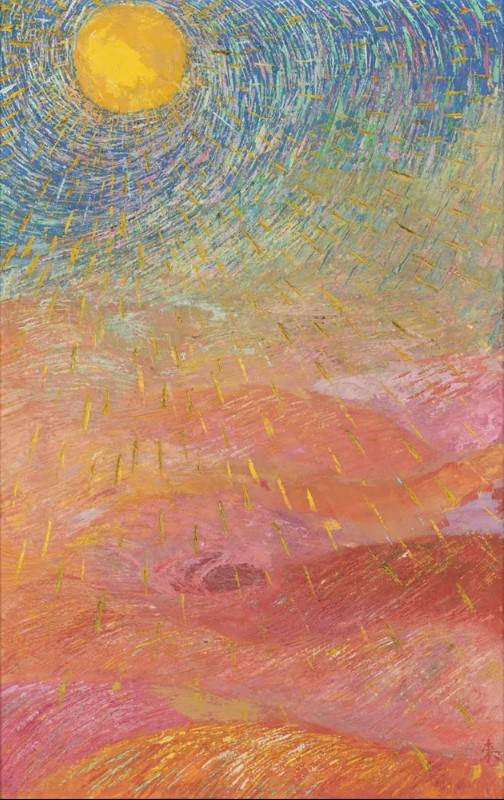

In [337]:
prediction = classifier("Cheese is the enemy.", )


print(prediction)
t_sad = getscore(0,prediction)
t_joy = getscore(1,prediction)
t_lov = getscore(2,prediction)
t_ang = getscore(3,prediction)
t_fea = getscore(4,prediction)
t_sur = getscore(5,prediction)

t_emotion = np.array((t_sad, t_joy, t_lov, t_ang, t_fea, t_sur))

# Compare distance with all images
distance = np.zeros([len(img_list)], dtype = numpy.float64)
for k in range(len(img_list)):
  distance[k] = distance_func(i_emotion[k], t_emotion)

print(distance)

min_distance_index = np.argmin(distance)
# print(min_distance_index)
img_out = Image.open(img_list[min_distance_index])
print(img_list[min_distance_index])
img_out
